<a href="https://colab.research.google.com/github/kxtubh/Startup-Scoring-Model/blob/main/Startup_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0. Imports and Dependencies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

#1. Data Exploration

In [2]:
df = pd.read_csv('Startup_Scoring_Dataset.csv')

In [3]:
df.head(10)

,startup_id,team_experience,market_size_million_usd,monthly_active_users,monthly_burn_rate_inr,funds_raised_inr,valuation_inr
0,S001,7,789,66299,6091495,4183839,263247468
1,S002,4,939,34866,9106842,666326,172927107
2,S003,8,42,73630,8817088,649150,313090455
3,S004,5,57,93657,6374167,20153173,305887183
4,S005,7,512,61187,841971,118834,84815222
5,S006,10,416,95939,551157,48939582,307433345
6,S007,3,583,68940,4428727,22725756,123865200
7,S008,7,737,54484,4174499,46422165,378403327
8,S009,8,814,51105,5996594,4422201,58978079
9,S010,5,108,46676,5156799,1079600,290161754


In [4]:
df.info() #checking for null objects

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   startup_id               100 non-null    object
 1   team_experience          100 non-null    int64 
 2   market_size_million_usd  100 non-null    int64 
 3   monthly_active_users     100 non-null    int64 
 4   monthly_burn_rate_inr    100 non-null    int64 
 5   funds_raised_inr         100 non-null    int64 
 6   valuation_inr            100 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 5.6+ KB


#2. Data Preprocessing

In [5]:
# For burn rate, we want lower values to get higher scores, hence we have to invert it
df['burn_rate_inverted'] = df['monthly_burn_rate_inr'].max() - df['monthly_burn_rate_inr']

In [6]:
#Features
features_to_normalize = [
    'team_experience',
    'market_size_million_usd',
    'monthly_active_users',
    'burn_rate_inverted',
    'valuation_inr'
]

In [7]:
#Min-Max normalization
scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

#3.Scoring Logic


In [8]:
weights = {
    'team_experience': 0.20,        # 20% - Team composition is imp
    'market_size_million_usd': 0.15,# 15% - Market opportunities
    'monthly_active_users': 0.25,   # 25% - Traction is key
    'monthly_burn_rate': 0.15,      # 15% - Financial efficiency
    'funds_raised_inr': 0.15,       # 15% - Funding validation
    'valuation_inr': 0.10           # 10% - Current valuation
}

In [9]:
def calculate_startup_score(row, weights):
    score = 0
    score += row['team_experience'] * weights['team_experience']
    score += row['market_size_million_usd'] * weights['market_size_million_usd']
    score += row['monthly_active_users'] * weights['monthly_active_users']
    score += (1 - row['monthly_burn_rate_inr']) * weights['monthly_burn_rate']  # Inverted
    score += row['funds_raised_inr'] * weights['funds_raised_inr']
    score += row['valuation_inr'] * weights['valuation_inr']
    return score * 100  # Scale to 0-100

# Apply scoring
df_normalized['health_score'] = df_normalized.apply(
    lambda row: calculate_startup_score(row, weights), axis=1
)

#4. Rank Startups

In [10]:
# Sort by score
df_ranked = df_normalized.sort_values('health_score', ascending=False).reset_index(drop=True)

# Get top 10 and bottom 10
top_10 = df_ranked.head(10)
bottom_10 = df_ranked.tail(10)

print("TOP 10 STARTUPS:")
print(top_10[['startup_id', 'health_score']].to_string())

print("\nBOTTOM 10 STARTUPS:")
print(bottom_10[['startup_id', 'health_score']].to_string())

TOP 10 STARTUPS:
  startup_id  health_score
0       S006  7.258264e+08
1       S033  7.084532e+08
2       S073  6.876916e+08
3       S077  6.759089e+08
4       S094  6.605813e+08
5       S050  6.514890e+08
6       S059  6.450394e+08
7       S060  6.347005e+08
8       S008  6.337151e+08
9       S035  6.299929e+08

BOTTOM 10 STARTUPS:
   startup_id  health_score
90       S025 -7.102212e+07
91       S063 -7.895959e+07
92       S075 -8.572508e+07
93       S055 -8.979324e+07
94       S095 -9.047137e+07
95       S040 -9.810611e+07
96       S078 -1.106196e+08
97       S058 -1.203656e+08
98       S003 -1.225190e+08
99       S002 -1.266077e+08


In [11]:
# why did top performer scored high
top_startup = df_ranked.iloc[0]
print(f"Top startup {top_startup['startup_id']} scored high because:")
print(f"- Team Experience: {top_startup['team_experience']:.2f}")
print(f"- Market Size: ${top_startup['market_size_million_usd']:.0f}M")
print(f"- Monthly Users: {top_startup['monthly_active_users']:.0f}")

Top startup S006 scored high because:
- Team Experience: 1.00
- Market Size: $0M
- Monthly Users: 1


In [24]:
#why did bottom perfomer score low
bottom_startup = df_ranked.iloc[-1]
print(f"Bottom startup {bottom_startup['startup_id']} scored low because:")
print(f"- Team Experience: {bottom_startup['team_experience']:.2f}")
print(f"- Market Size: ${bottom_startup['market_size_million_usd']:.0f}M")
print(f"- Monthly Users: {bottom_startup['monthly_active_users']:.0f}")

Bottom startup S002 scored low because:
- Team Experience: 0.33
- Market Size: $1M
- Monthly Users: 0


#5. Visualization

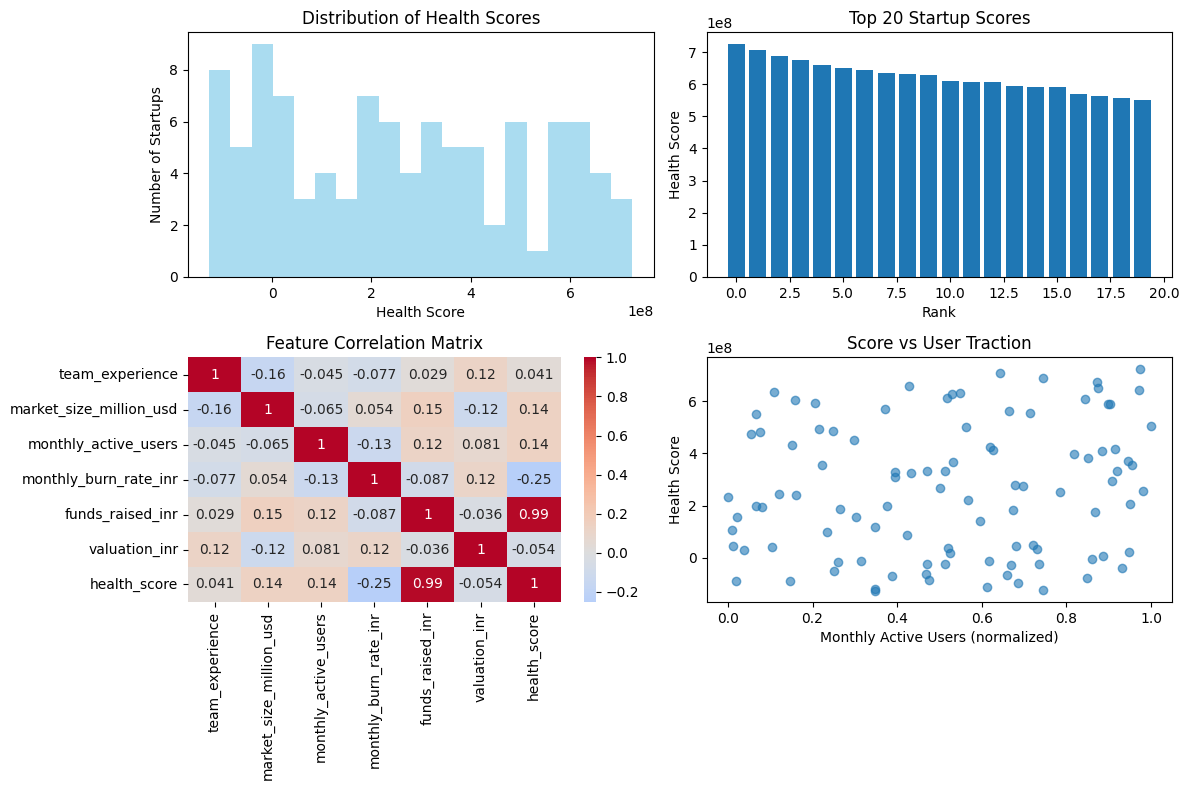

In [23]:
plt.figure(figsize=(12, 8))

# 1. Score histogram
plt.subplot(2, 2, 1)
plt.hist(df_ranked['health_score'], bins=20, alpha=0.7, color='skyblue')
plt.title('Distribution of Health Scores')
plt.xlabel('Health Score')
plt.ylabel('Number of Startups')

# 2. Top 20 scores bar chart
plt.subplot(2, 2, 2)
top_20 = df_ranked.head(20)
plt.bar(range(len(top_20)), top_20['health_score'])
plt.title('Top 20 Startup Scores')
plt.xlabel('Rank')
plt.ylabel('Health Score')

# 3. Feature correlation heatmap
plt.subplot(2, 2, 3)
corr_features = ['team_experience', 'market_size_million_usd', 'monthly_active_users',
                'monthly_burn_rate_inr', 'funds_raised_inr', 'valuation_inr', 'health_score']
corr_matrix = df_ranked[corr_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')

# 4. Score vs individual features
plt.subplot(2, 2, 4)
plt.scatter(df_ranked['monthly_active_users'], df_ranked['health_score'], alpha=0.6)
plt.xlabel('Monthly Active Users (normalized)')
plt.ylabel('Health Score')
plt.title('Score vs User Traction')

plt.tight_layout()
plt.show()

#6. Unsupervised Approach [ basically another way ]

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

# Clustering for startup segments
kmeans = KMeans(n_clusters=4, random_state=42)
df_ranked['cluster'] = kmeans.fit_predict(df_normalized[features_to_normalize])

In [27]:
import plotly.express as px

# Interactive scatter plot
fig = px.scatter(df_ranked,
                x='monthly_active_users',
                y='health_score',
                size='valuation_inr',
                color='team_experience',
                hover_data=['startup_id'])
fig.show()